## Workshop: Tuning Threshold and Automated Hyperparameter Tuning

This notebook provides code for workshop assignment [Tuning Threshold and Automated Hyperparameter Tuning](https://hiof.instructure.com/courses/9934/assignments/47613)  

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import TunedThresholdClassifierCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import GridSearchCV, StratifiedKFold


The following code for processing and training models has been copied from workshop1009.ipynb. The training code will be replaces shortly.

In [9]:
dataset = pd.read_csv('../data/heart_failure/heart_failure_clinical_records_dataset.csv')
dataset.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [10]:
dataset.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [11]:
dataset['DEATH_EVENT'].value_counts()

DEATH_EVENT
0    203
1     96
Name: count, dtype: int64

In [46]:
features = dataset.drop('DEATH_EVENT', axis=1)

In [12]:
# Random sampling
# train = dataset.sample(frac=0.8)
# test = dataset.drop(train.index)

#Stratified sampling
trainvalidation = dataset.groupby('DEATH_EVENT', group_keys=False)[dataset.columns].sample(frac=0.8)
test = dataset.drop(trainvalidation.index)
train = trainvalidation.groupby('DEATH_EVENT', group_keys=False)[dataset.columns].sample(frac=0.75)
validation = trainvalidation.drop(train.index)

print(train['DEATH_EVENT'].value_counts()/train.shape[0])
print(validation['DEATH_EVENT'].value_counts()/validation.shape[0])
print(test['DEATH_EVENT'].value_counts()/test.shape[0])

DEATH_EVENT
0    0.677778
1    0.322222
Name: count, dtype: float64
DEATH_EVENT
0    0.677966
1    0.322034
Name: count, dtype: float64
DEATH_EVENT
0    0.683333
1    0.316667
Name: count, dtype: float64


In [13]:
train_features = train.drop('DEATH_EVENT', axis=1)
train_targets = train['DEATH_EVENT']
validation_features = validation.drop('DEATH_EVENT', axis=1)
validation_targets = validation['DEATH_EVENT']
test_features = test.drop('DEATH_EVENT', axis=1)
test_targets = test['DEATH_EVENT']

In [14]:
dt1 = DecisionTreeClassifier()
dt1.fit(train_features, train_targets)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [15]:
dt1.score(test_features, test_targets)


0.7333333333333333

In [16]:
def confusion(classifier):
    ConfusionMatrixDisplay.from_estimator(classifier, test_features, test_targets)

def roc_curve(classifier):
    RocCurveDisplay.from_estimator(classifier, test_features, test_targets)

def test(classifier):
    evaluate_model(classifier, test_features, test_targets)

def validate(classifier):
    print('Training results:')
    evaluate_model(classifier, train_features, train_targets)
    print('Validation results:')
    evaluate_model(classifier, validation_features, validation_targets)

def evaluate_model(classifier, features, targets):
    predictions = classifier.predict(features)
    accuracy = accuracy_score(targets, predictions)
    precision = precision_score(targets, predictions)
    recall = recall_score(targets, predictions)
    f1 = f1_score(targets, predictions)
    roc_auc = roc_auc_score(targets, predictions)

    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1: {f1:.2f}')
    print(f'ROCAUC: {roc_auc:.2f}')

In [17]:
validate(dt1)

Training results:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1: 1.00
ROCAUC: 1.00
Validation results:
Accuracy: 0.71
Precision: 0.56
Recall: 0.47
F1: 0.51
ROCAUC: 0.65


In [18]:
dt2 = DecisionTreeClassifier(max_depth=3)
dt2.fit(train_features, train_targets)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [19]:
validate(dt2)

Training results:
Accuracy: 0.91
Precision: 0.89
Recall: 0.81
F1: 0.85
ROCAUC: 0.88
Validation results:
Accuracy: 0.78
Precision: 0.67
Recall: 0.63
F1: 0.65
ROCAUC: 0.74


In [20]:
dt3 = DecisionTreeClassifier(max_depth=7, min_samples_split=5, min_samples_leaf=2, min_weight_fraction_leaf=0.05, max_leaf_nodes=12, class_weight='balanced')
dt3.fit(train_features, train_targets)
validate(dt3)

Training results:
Accuracy: 0.86
Precision: 0.72
Recall: 0.91
F1: 0.80
ROCAUC: 0.87
Validation results:
Accuracy: 0.73
Precision: 0.57
Recall: 0.63
F1: 0.60
ROCAUC: 0.70


In [21]:
nb1 = GaussianNB()
nb1.fit(train_features, train_targets)
validate(nb1)

Training results:
Accuracy: 0.81
Precision: 0.83
Recall: 0.52
F1: 0.64
ROCAUC: 0.73
Validation results:
Accuracy: 0.78
Precision: 0.88
Recall: 0.37
F1: 0.52
ROCAUC: 0.67


In [22]:
nb2 = GaussianNB(var_smoothing=1e-7)
nb2.fit(train_features, train_targets)
validate(nb2)

Training results:
Accuracy: 0.80
Precision: 0.84
Recall: 0.47
F1: 0.60
ROCAUC: 0.71
Validation results:
Accuracy: 0.80
Precision: 0.89
Recall: 0.42
F1: 0.57
ROCAUC: 0.70


In [23]:
nb3 = GaussianNB(var_smoothing=1e-11)
nb3.fit(train_features, train_targets)
validate(nb3)

Training results:
Accuracy: 0.78
Precision: 0.76
Recall: 0.48
F1: 0.59
ROCAUC: 0.70
Validation results:
Accuracy: 0.75
Precision: 0.70
Recall: 0.37
F1: 0.48
ROCAUC: 0.65


In [24]:
print('DecisionTree')
test(dt3)
print('NaiveBayes')
test(nb1)

DecisionTree
Accuracy: 0.80
Precision: 0.64
Recall: 0.84
F1: 0.73
ROCAUC: 0.81
NaiveBayes
Accuracy: 0.83
Precision: 0.85
Recall: 0.58
F1: 0.69
ROCAUC: 0.77


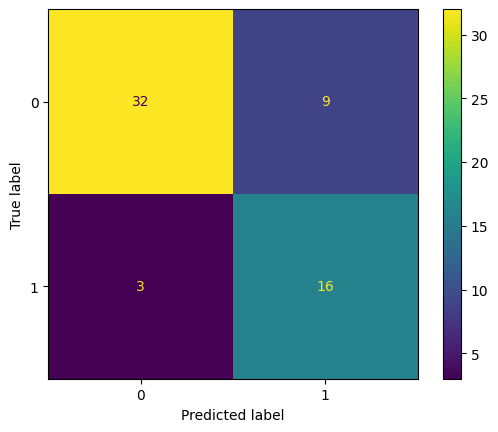

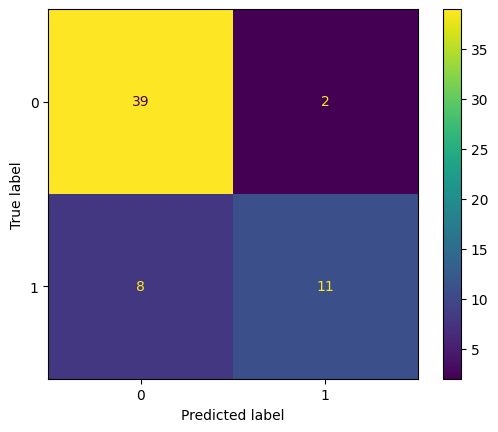

In [25]:
confusion(dt3)
confusion(nb1)

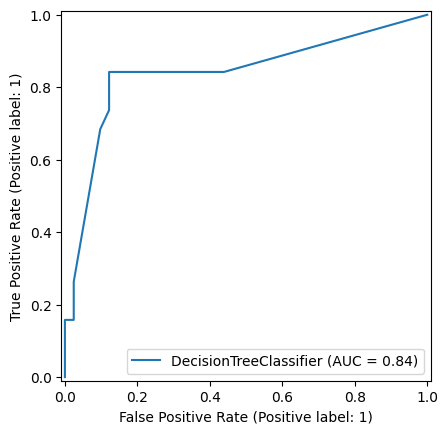

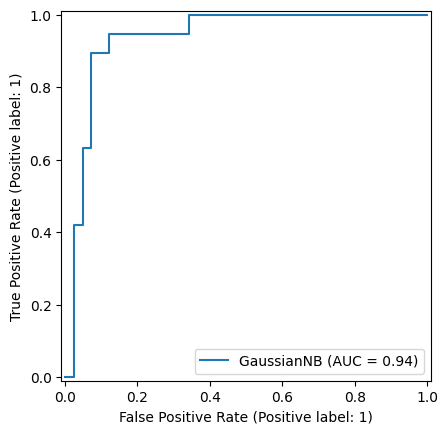

In [26]:
roc_curve(dt3)
roc_curve(nb1)

### Tuning the threshold manually
The following code shows how to plot NegativePredictiveValue (NPV) vs. True Negative Rate (TNR) and allows you to find the optimal threshold for screening, both manually and through the use of TunedThresholdClassifierCV

The optimal threshold for screening would be perfect NPV i.e. no false negatives and as high TNR as possible i.e. identify as many true negative cases as possible

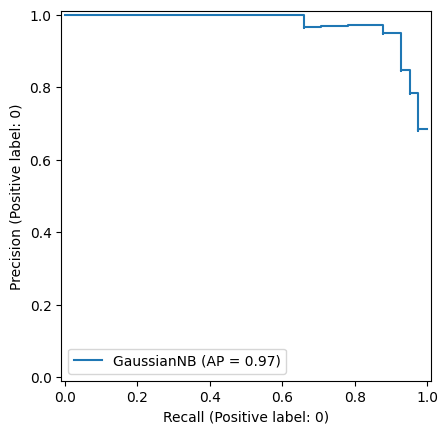

In [27]:
# PrecisionRecallDisplay (as well as the underlying score functions) allow you to specify which class to consider 
# positive i.e. whether to measure the performance on target class 1 (heart failure) or 0 (no heart failure). Precision 
# and Recall with pos_label=0 is NPV and TNR respectively.
PrecisionRecallDisplay.from_estimator(nb1, test_features, test_targets, pos_label=0)

In [28]:
# Find the probabilities of each class for all test instances
nb1_predictions = nb1.predict_proba(test_features)
# Loop through the sorted unique probabilities for the instance belonging to 0 (no heart failure)
unique = np.unique(nb1_predictions[:,0])
for threshold in unique:
    # Convert the probabilities to predictions using the current threshold
    threshold_predictions = (nb1_predictions[:,0] < threshold)*1
    # Calculate the scores for NPV and TNR for the current threshold predictions
    npv = precision_score(test_targets, threshold_predictions,pos_label=0,zero_division=1)
    tnr = recall_score(test_targets, threshold_predictions,pos_label=0)
    # Print the results
    print(f'Threshold: {threshold:.2f}',npv,tnr)

Threshold: 0.00 0.6833333333333333 1.0
Threshold: 0.01 0.6779661016949152 0.975609756097561
Threshold: 0.09 0.6896551724137931 0.975609756097561
Threshold: 0.12 0.7017543859649122 0.975609756097561
Threshold: 0.16 0.7142857142857143 0.975609756097561
Threshold: 0.21 0.7272727272727273 0.975609756097561
Threshold: 0.24 0.7407407407407407 0.975609756097561
Threshold: 0.30 0.7547169811320755 0.975609756097561
Threshold: 0.32 0.7692307692307693 0.975609756097561
Threshold: 0.35 0.7843137254901961 0.975609756097561
Threshold: 0.37 0.78 0.9512195121951219
Threshold: 0.40 0.7959183673469388 0.9512195121951219
Threshold: 0.48 0.8125 0.9512195121951219
Threshold: 0.52 0.8297872340425532 0.9512195121951219
Threshold: 0.55 0.8478260869565217 0.9512195121951219
Threshold: 0.58 0.8444444444444444 0.926829268292683
Threshold: 0.62 0.8636363636363636 0.926829268292683
Threshold: 0.62 0.8837209302325582 0.926829268292683
Threshold: 0.68 0.9047619047619048 0.926829268292683
Threshold: 0.69 0.9268292682

In [29]:
# A custom classifier class that can use a specified classification threshold
class ThresholdClassifier(BaseEstimator, ClassifierMixin):
   def __init__(self, estimator, threshold=0.5): 
       self.estimator = estimator
       self.threshold = threshold

   def fit(self, X, y):
       if hasattr(self.estimator, 'classes_'):
            self.classes_ = self.estimator.classes_
            return self
       self.estimator.fit(X, y)
       return self

   def predict(self, X):
    #    proba = self.estimator.predict_proba(X)[:, 1]
       proba = self.estimator.predict_proba(X)[:, 0]
       return (proba < self.threshold).astype(int)

   def predict_proba(self, X):
       return self.estimator.predict_proba(X)


In [30]:
nb_threshold = ThresholdClassifier(estimator=nb1, threshold=0.95)
predictions = nb_threshold.predict(test_features)
print(precision_score(test_targets, predictions, pos_label=0, zero_division=1))
print(recall_score(test_targets, predictions, pos_label=0))

1.0
0.4634146341463415


In [31]:
nb_tunedthreshold = TunedThresholdClassifierCV(estimator=GaussianNB(), cv=5, scoring=make_scorer(fbeta_score, beta=0.03, pos_label=0, zero_division=1))
# nb_tunedthreshold = TunedThresholdClassifierCV(estimator=GaussianNB(), cv=5, scoring=make_scorer(precision_score, pos_label=0, zero_division=1))
nb_tunedthreshold.fit(train_features, train_targets)
nb_tunedthreshold_predictions = nb_tunedthreshold.predict(test_features)
print(precision_score(test_targets, nb_tunedthreshold_predictions, pos_label=0, zero_division=1))
print(recall_score(test_targets, nb_tunedthreshold_predictions, pos_label=0))


1.0
0.2682926829268293


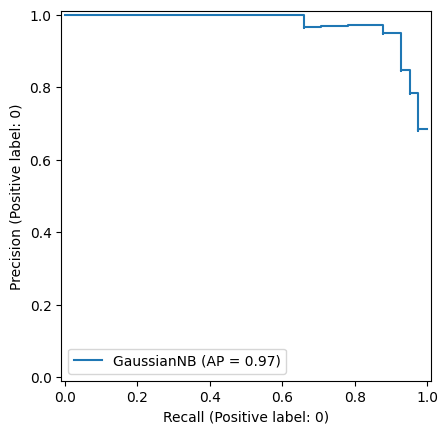

In [32]:
PrecisionRecallDisplay.from_estimator(nb_tunedthreshold.estimator_, test_features, test_targets, pos_label=0)

In [44]:
dt_params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [1,2,4,None]
}
dt = GridSearchCV(DecisionTreeClassifier(), 
        dt_params, 
        cv=StratifiedKFold(5))
dt.fit(train_features, train_targets)
dt_cv_results = pd.DataFrame(dt.cv_results_)
dt_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002303,0.000791,0.001695,0.000484,gini,1,"{'criterion': 'gini', 'max_depth': 1}",0.694444,0.888889,0.833333,0.888889,0.833333,0.827778,0.071146,1
1,0.001167,0.000039,0.000811,0.000006,gini,2,"{'criterion': 'gini', 'max_depth': 2}",0.750000,0.750000,0.861111,0.888889,0.805556,0.811111,0.056656,6
2,0.001250,0.000020,0.000827,0.000006,gini,4,"{'criterion': 'gini', 'max_depth': 4}",0.750000,0.777778,0.805556,0.805556,0.750000,0.777778,0.024845,9
3,0.001319,0.000034,0.000831,0.000023,gini,None,"{'criterion': 'gini', 'max_depth': None}",0.722222,0.777778,0.777778,0.805556,0.777778,0.772222,0.027217,10
4,0.001061,0.000007,0.000793,0.000015,entropy,1,"{'criterion': 'entropy', 'max_depth': 1}",0.694444,0.888889,0.833333,0.888889,0.833333,0.827778,0.071146,1
5,0.001126,0.000005,0.000795,0.000021,entropy,2,"{'criterion': 'entropy', 'max_depth': 2}",0.750000,0.777778,0.861111,0.888889,0.833333,0.822222,0.051520,4
6,0.001255,0.000019,0.000808,0.000018,entropy,4,"{'criterion': 'entropy', 'max_depth': 4}",0.722222,0.833333,0.722222,0.888889,0.777778,0.788889,0.064788,8
7,0.001323,0.000019,0.000817,0.000022,entropy,None,"{'criterion': 'entropy', 'max_depth': None}",0.750000,0.777778,0.750000,0.805556,0.777778,0.772222,0.020787,10
8,0.001048,0.000010,0.000798,0.000016,log_loss,1,"{'criterion': 'log_loss', 'max_depth': 1}",0.694444,0.888889,0.833333,0.888889,0.833333,0.827778,0.071146,1
9,0.001154,0.000026,0.000818,0.000009,log_loss,2,"{'criterion': 'log_loss', 'max_depth': 2}",0.750000,0.777778,0.861111,0.888889,0.833333,0.822222,0.051520,4


<Axes: xlabel='param_criterion', ylabel='mean_test_score'>

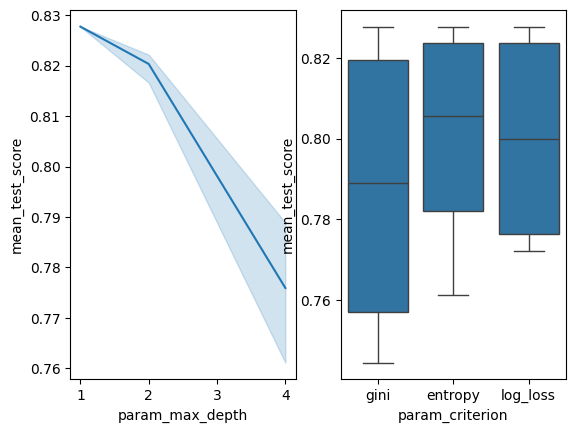

In [41]:
dt_param_scores = dt_cv_results[['param_criterion', 'param_max_depth', 'mean_test_score']]
fig, ax = plt.subplots(1,2)
sb.lineplot(data=dt_param_scores, x='param_max_depth', y='mean_test_score', ax=ax[0])
sb.boxplot(data=dt_param_scores, x='param_criterion', y='mean_test_score', ax=ax[1])

In [ ]:
# Start of nested cross validation. Will be finished in the next workshop
dt_params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [1,2,4,None]
}
outer_cv = StratifiedKFold(5)
inner_cv = StratifiedKFold(4)

for (train_index, test_index) in list(outer_cv.split(features)):
    train_features = features.iloc[train_index]
    test_features = features.iloc[test_index]
    dt = GridSearchCV(DecisionTreeClassifier(), 
            dt_params, 
            cv=StratifiedKFold(5))
    dt.fit(train_features, train_targets)
    dt_cv_results = pd.DataFrame(dt.cv_results_)
    dt_cv_results